# Software Based Gaze tracking modeling training and result plotting

## 1 data analysis

### 1.0 trial of using logic regression to classify saccad and fixation

In [14]:
from utils.arffloader import Loader
import numpy as np

import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.utils import shuffle
Data = Loader("/Users/louitech_zero/VoidGaze/data/TotalDataSet.npy")

data = shuffle(Data, random_state=1)
T = 150000
testf = data[T:,2:-1]
testt = data[T:,-1]

feature = data[:T,2:-1]
target = data[:T,-1]




clf = LogisticRegression(random_state=0,penalty='l1',solver ='liblinear').fit(feature, target)
pred = clf.predict(testf)

print("without PCA : ",clf.score(testf, testt))
print("precision   : ",metrics.precision_score(pred,testt,average=None))
print("  recall    : ",metrics.recall_score(pred,testt,average=None))
print(np.transpose(metrics.confusion_matrix(pred,testt)))

clf.coef_

without PCA :  0.7903016671077004
precision   :  [0.99603075 0.01631907]
  recall    :  [0.79207288 0.52217742]
[[59472   237]
 [15612   259]]


array([[ 0.11627566,  0.09428475,  0.03412889,  1.75725365, -4.11779634,
         0.80966288]])

### 1.1 visualize the head  velocity profile of different gaze behavior

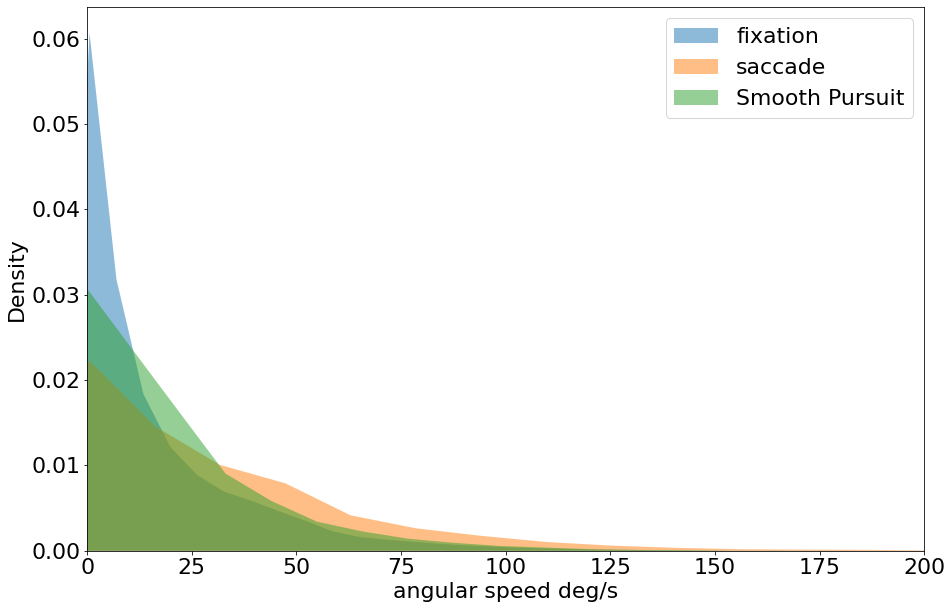

In [10]:
# visualize the velocity distribution of saccade, dixation , smooth pursuit head velocity
# the results show that the saccade and smooth pursuit are similar, therefore I decide to merge them
import seaborn as sns
from scipy.stats import norm
plt.rcParams.update({'font.size': 22})
data = Loader("/Users/louitech_zero/VoidGaze/data/TotalDataSet2.npy")
fixation = data[data[:,-1]==0]
saccade = data[data[:,-1]==1]
SP = data[data[:,-1]==2]
fig = plt.figure(figsize=(15,10))


sns.kdeplot(
   data=abs(fixation[:,-2])*180/np.pi,
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0,
)
sns.kdeplot(
   data=abs(saccade[:,-2])*180/np.pi,
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0,
)
sns.kdeplot(
   data=abs(SP[:,-2])*180/np.pi,
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0,
)



'''
sns.kdeplot(
   data=abs(SP[:,-2])*180/pi,
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0,
)
'''

plt.legend(labels=['fixation','saccade','Smooth Pursuit'])#,'smooth pursuit'
plt.xlim(0, 200)
#plt.ylim(0, 0.001)
plt.xlabel("angular speed deg/s")
plt.show()


fig.savefig("/Users/louitech_zero/Desktop/velocity_profile.png")

### 1.2 load head and gaze data to analyze the diiference betweeen saccade and fixation

In [222]:
d1 = Loader("/Users/louitech_zero/VoidGaze/data/TrainSet.npy")
d2 = Loader("/Users/louitech_zero/VoidGaze/data/TestSet.npy")
da = np.append(d1,d2,axis = 0)
print(da.shape)

(225580, 9)


In [223]:
np.save("/Users/louitech_zero/VoidGaze/data/TotalDataSet.npy",da)

In [1]:
from utils.arffloader import *
from src.preProcess import *
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt


In [1]:

def shift(target):
    data, meta =loadArff("/Users/louitech_zero/Desktop/360_em_dataset/ground_truth/train/004_07_football_hFc9HUYRbKc.arff")
    if target == -1:
        dataArray = data
    else:
        dataArray = data[data[:,-1] == target]
    CartGaze = np.zeros((len(dataArray),3,1))
    CartHead = np.zeros((len(dataArray),3,1))
    headV = np.zeros((len(dataArray),1))
    gazeshift = np.zeros((len(dataArray),1))
    
    Gaze_FOV = np.zeros((len(dataArray),3,1))
    for i in range(len(dataArray)):
        (CartHead[i],CartGaze[i],Gaze_FOV[i]) = PosTransform(dataArray[i],meta)

    headl = np.zeros((3,1))
    for i in range(len(CartHead)-1):
        i += 1
        headv = AngularDisp(CartHead[i],headl)/(dataArray[i,0]-dataArray[i-1,0])
        headV[i] = headv * 1000000 *180/pi
        headl = CartHead[i]
        gazeshift[i] =AngularDisp(CartGaze[i],CartHead[i])*180/pi
    return headV, gazeshift, Gaze_FOV, CartHead

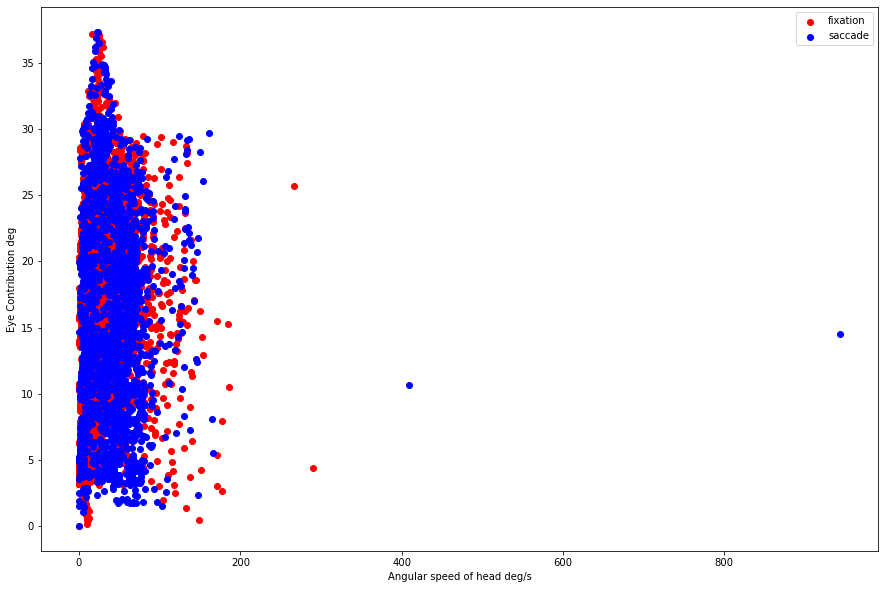

In [2]:
#plot the relationship between head velocity and gaze contribution for saccade and fixtion

fig = plt.figure(figsize=(15,10))

headVF, gazeshiftF , a , b= shift(0)
headVS, gazeshiftS, c, d = shift(1)

plt.scatter(headVF,gazeshiftF,color='red')
plt.scatter(headVS,gazeshiftS,color='blue')

plt.legend(labels=['fixation','saccade'])#,'smooth pursuit'


plt.ylabel("Eye Contribution deg")
plt.xlabel("Angular speed of head deg/s")
plt.show()


fig.savefig("/Users/louitech_zero/Desktop/DvsV.png")

In [ ]:
# the above trials indicate that it is not possible to distinguish saccade and fixation with head data only

### 1.3 split gaze trajectories from the whole dataset

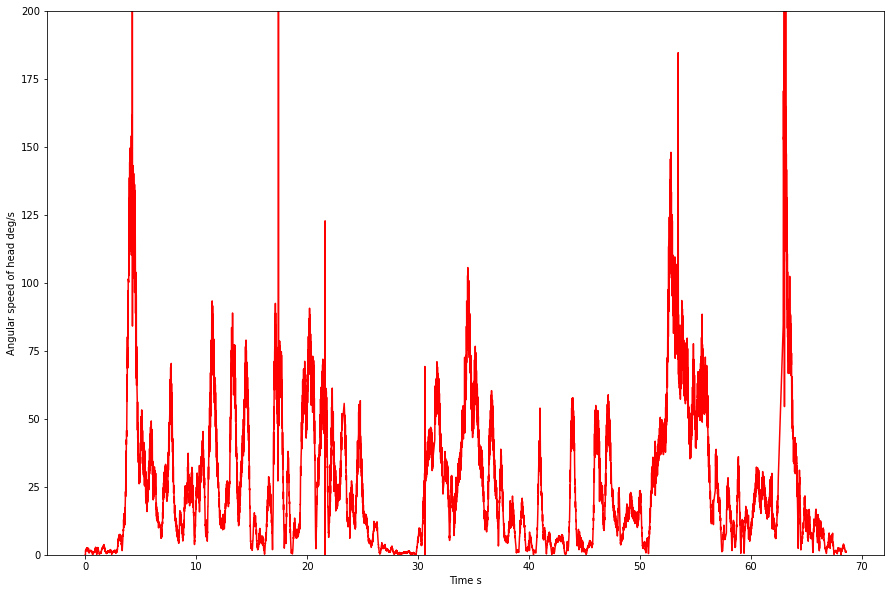

In [3]:
fig = plt.figure(figsize=(15,10))

headV, _ , Gaze_FOV, CartHead = shift(-1)
data, meta =loadArff("/Users/louitech_zero/Desktop/360_em_dataset/ground_truth/train/004_07_football_hFc9HUYRbKc.arff")

plt.plot(data[:,0]/1000000,headV,color='red')

#plt.legend(labels=['fixation','saccade'])#,'smooth pursuit'
plt.ylim(0, 200)

plt.ylabel("Angular speed of head deg/s")
plt.xlabel("Time s")
plt.show()

### use kalman filter to remove noise

"\npylab.figure()  \nvalid_iter = range(1,n_iter) # Pminus not valid at step 0  \npylab.plot(valid_iter,Pminus[valid_iter],label='a priori error estimate')  \npylab.xlabel('Iteration')  \npylab.ylabel('$(Voltage)^2$')  \npylab.setp(pylab.gca(),'ylim',[0,.01])  \npylab.show()  \n"

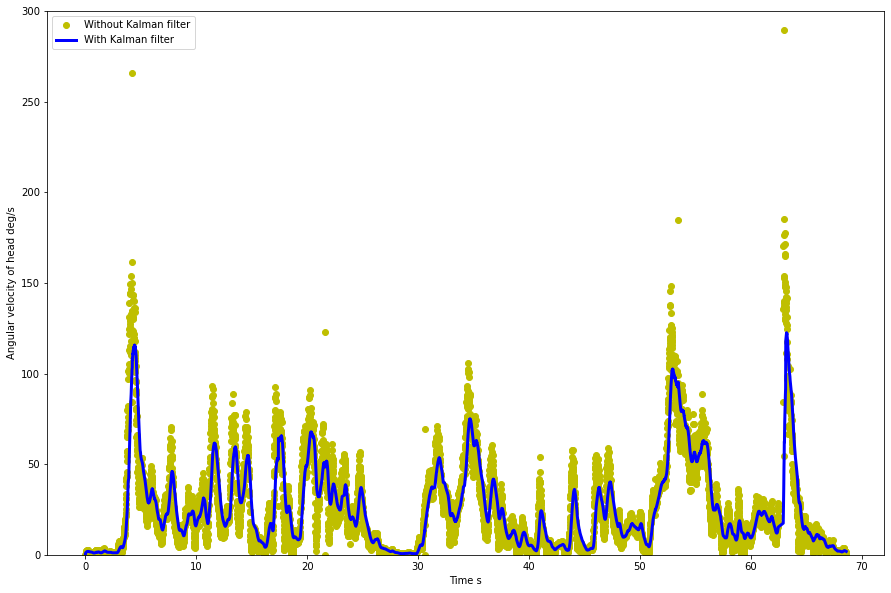

In [4]:


     

xhat = kalman_filter(headV)
figfilted = plt.figure(figsize=(15,10))  
plt.plot(data[:,0]/1000000,headV,'yo',linewidth=3)     #观测值  
plt.plot(data[:,0]/1000000,xhat,color = 'blue',linewidth=3)  #滤波估计值  
#plt.axhline(x,color='g',label='truth value')    #真实值  
plt.legend(['Without Kalman filter','With Kalman filter'])  
plt.xlabel('Time s')  
plt.ylabel('Angular velocity of head deg/s')  

plt.ylim(0, 300)
figfilted.savefig("/Users/louitech_zero/Desktop/kalman.png")
'''
pylab.figure()  
valid_iter = range(1,n_iter) # Pminus not valid at step 0  
pylab.plot(valid_iter,Pminus[valid_iter],label='a priori error estimate')  
pylab.xlabel('Iteration')  
pylab.ylabel('$(Voltage)^2$')  
pylab.setp(pylab.gca(),'ylim',[0,.01])  
pylab.show()  
'''  


### simillar operation is done on acceleration

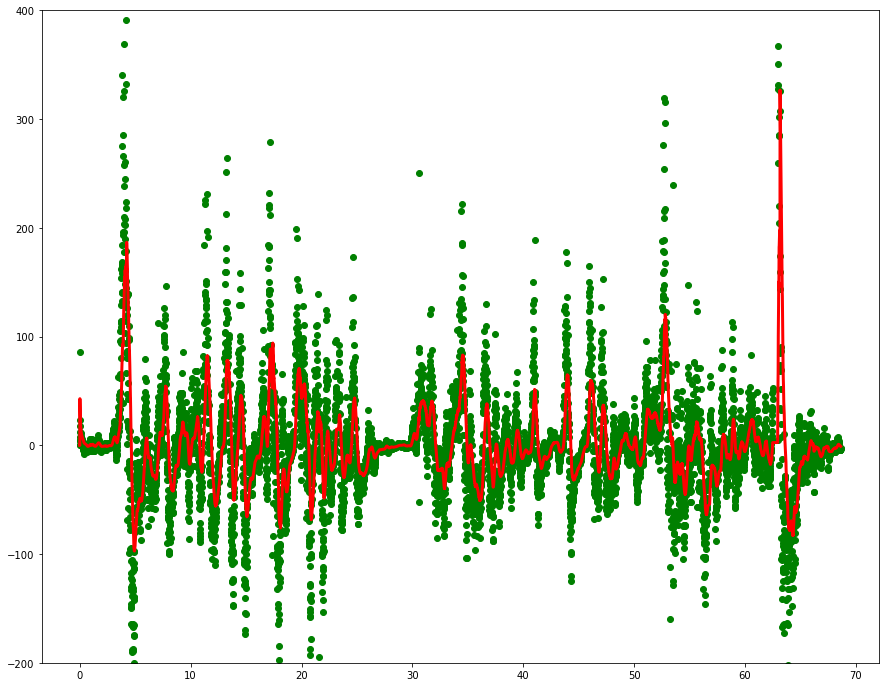

In [6]:
acceleration = np.zeros((len(xhat),1))
for i in range(len(xhat)-1):
    i+=1
    acceleration[i] = (xhat[i] - xhat[i-1])/(data[i,0]/1000000 - data[i-1,0]/1000000)


figa = plt.figure(figsize = (15, 12))
'''
for i in range(len(acceleration)):
    if abs(acceleration[i]) <= 2:
        plt.plot(data[i,0]/1000000,acceleration[i],'bo')
'''

plt.plot(data[:,0]/1000000,acceleration,'go')
acceleration_smoothed = kalman_filter(acceleration,Q = 1e-5)
plt.plot(data[:,0]/1000000,acceleration_smoothed,'r',linewidth=3)
plt.ylim(-200,400)

Stationary_Points = []
Trajectory_ends = []
for index, i in enumerate(acceleration_smoothed):
    if abs(i) < 2:
        Stationary_Points.append(index)

for i in range(len(Stationary_Points)-1):
    i+=1
    if Stationary_Points[i] - Stationary_Points[i-1] >= 20:
        Trajectory_ends.append([Stationary_Points[i-1],Stationary_Points[i]])

# 1.4 derive and analyze 3D plots of head rotation

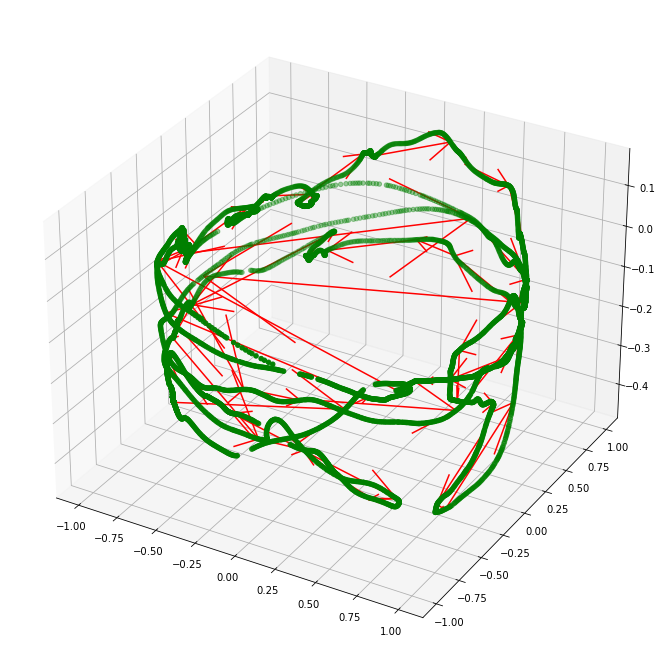

In [7]:
# splite gaze trajectories according to head moving direction
figvector = plt.figure(figsize = (15, 12))
axvector = figvector.add_subplot(projection='3d')
for i in Trajectory_ends:
    #axvector.plot3D(np.array([CartHead[i[0],0],CartHead[i[1],0]]),np.array([CartHead[i[0],2],CartHead[i[1],2]]),np.array([CartHead[i[0],1],CartHead[i[1],1]]))
    axvector.quiver(CartHead[i[0],0],CartHead[i[0],2],CartHead[i[0],1],CartHead[i[1],0]-CartHead[i[0],0],CartHead[i[1],2]-CartHead[i[0],2],CartHead[i[1],1]-CartHead[i[0],1],color = 'red')
axvector.scatter3D(CartHead[:,0], CartHead[:,2], CartHead[:,1], color = "green")


### 1.5 The behavior gaze distribution by splitting head movements according to velocity

In [244]:
# splite dataset by head direction
up_right = np.zeros((2,1))
up_left = np.zeros((2,1))
down_right = np.zeros((2,1))
down_left = np.zeros((2,1))

up_right_feature = np.zeros((5,1))
up_left_feature = np.zeros((5,1))
down_right_feature = np.zeros((5,1))
down_left_feature = np.zeros((5,1))
for i in range(len(V)):
    if V[i,0] > 0 and V[i,1] > 0:
        up_right = np.append(up_right,Equrect[i,:].reshape(2,1),axis = 1)
        up_right_feature = np.append(up_right_feature,feature[i,:].reshape(5,1),axis = 1)
    elif V[i,0] > 0 and V[i,1] < 0:
        down_right = np.append(down_right,Equrect[i,:].reshape(2,1),axis = 1)
        down_right_feature = np.append(down_right_feature,feature[i,:].reshape(5,1),axis = 1)
    elif V[i,0] < 0 and V[i,1] > 0:
        up_left = np.append(up_left,Equrect[i,:].reshape(2,1),axis = 1)
        up_left_feature = np.append(up_left_feature,feature[i,:].reshape(5,1),axis = 1)
    else:
        down_left = np.append(down_left,Equrect[i,:].reshape(2,1),axis = 1)
        down_left_feature = np.append(down_left_feature,feature[i,:].reshape(5,1),axis = 1)
up_right = up_right.T[1:,:]
up_left = up_left.T[1:,:]
down_right = down_right.T[1:,:]
down_left = down_left.T[1:,:]


up_right_feature = up_right_feature.T[1:,:]
up_left_feature = up_left_feature.T[1:,:]
down_right_feature = down_right_feature.T[1:,:]
down_left_feature = down_left_feature.T[1:,:]

<ipython-input-402-6893bebaa2de>:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("direction.png", dpi=500)


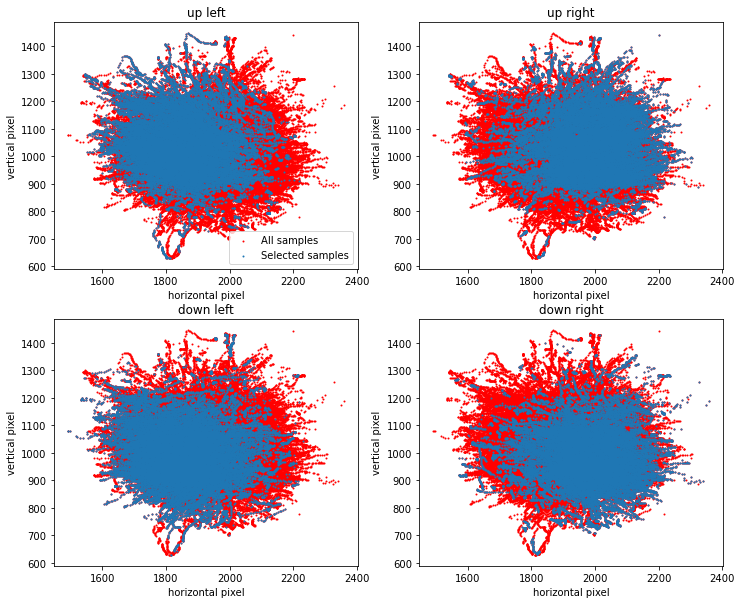

In [402]:
# the size of cone of vision reduced by splitting gaze samples in to 4 head drections
plt.figure(1,figsize = (12,10))


plt.subplot(221)
plt.scatter(equrect[:,0],equrect[:,1],1,color = 'r',label = 'All samples')
plt.scatter(up_left[:,0]*3840,up_left[:,1]*2048,1,label = 'Selected samples')
plt.xlabel("horizontal pixel")
plt.ylabel("vertical pixel")
plt.title("up left")
plt.legend()

plt.subplot(222)
plt.scatter(equrect[:,0],equrect[:,1],1,color = 'r')
plt.scatter(up_right[:,0]*3840,up_right[:,1]*2048,1)
plt.xlabel("horizontal pixel")
plt.ylabel("vertical pixel")
plt.title("up right")

plt.subplot(223)
plt.scatter(equrect[:,0],equrect[:,1],1,color = 'r')
plt.scatter(down_left[:,0]*3840,down_left[:,1]*2048,1)
plt.xlabel("horizontal pixel")
plt.ylabel("vertical pixel")
plt.title("down left")

plt.subplot(224)
plt.scatter(equrect[:,0],equrect[:,1],1,color = 'r')
plt.scatter(down_right[:,0]*3840,down_right[:,1]*2048,1)
plt.xlabel("horizontal pixel")
plt.ylabel("vertical pixel")
plt.title("down right")
#plt.savefig("direction.png", dpi=500)

In [ ]:
# inspired by the result above the GMM is used to decompose the samples

## 2 Analysis with unsupervised learning

In [1]:
import itertools
from scipy import linalg
import matplotlib as mpl
from sklearn.mixture import GaussianMixture
from preProcess import *
import numpy as np
import numpy
from utils.arffloader import *
import matplotlib.pyplot as plt

In [3]:
import matplotlib
font = {'weight' :  'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

### 2.1 Preprocess dataset

In [2]:
from preProcess import *
import os
from utils.arffloader import *
directory = '/Users/louitech_zero/Desktop/360_em_dataset/ground_truth/test/'
files = []
for r, d, f in os.walk(directory):
    for file in f:
        files.append(os.path.join(r, file))
directory = '/Users/louitech_zero/Desktop/360_em_dataset/ground_truth/train/'
for r, d, f in os.walk(directory):
    for file in f:
        files.append(os.path.join(r, file))
    

count = 0

for i in files:
    gazedata = GazeHeadMovement(i)
    gaze_equrect = np.zeros((len(gazedata.gaze_fov),2))
    v,a = gazedata.getEquirectRes()
    h = gazedata.angle_head
    for j in range(len(gazedata.gaze_fov)):
        Rads = Cart2Spher(gazedata.gaze_fov[j])
        gaze_equrect[j] = Spher2Equ(Rads[0],Rads[1],gazedata.meta['width_px'],gazedata.meta["height_px"])    
    if count == 0:
        equrect = gaze_equrect
        V = v
        A = a
        head_pose = h
        BreakPoint = [len(a)]
        size = [gazedata.meta['height_px']]
        
    else:
        equrect = np.append(equrect,gaze_equrect,axis = 0 )
        V = np.append(V,v,axis = 0 )
        A = np.append(A,a,axis = 0 )
        head_pose = np.append(head_pose,h,axis = 0 )
        BreakPoint.append(len(a))
        size.append(gazedata.meta['height_px'])
    count+=1


for i in range(len(V)):
    if abs(V[i,0]) > 2500:
        V[i] = V[i-1]
    if abs(A[i,0]) > 2500:
        A[i] = A[i-1]     
    if abs(V[i,1]) > 1500:
        V[i] = V[i-1]
    if abs(A[i,1]) > 1500:
        A[i] = A[i-1] 
                 

In [3]:
# normalize abnormal values
def normalize(data,breakpoint,height):
    pointer = 0
    newdata = data
    newdata[:,0]/=3840
    for i,j in enumerate(BreakPoint):
        newdata[pointer:pointer+j,1] /= height[i]
        pointer += j
    return newdata
        


### 2.2 Visualize Data

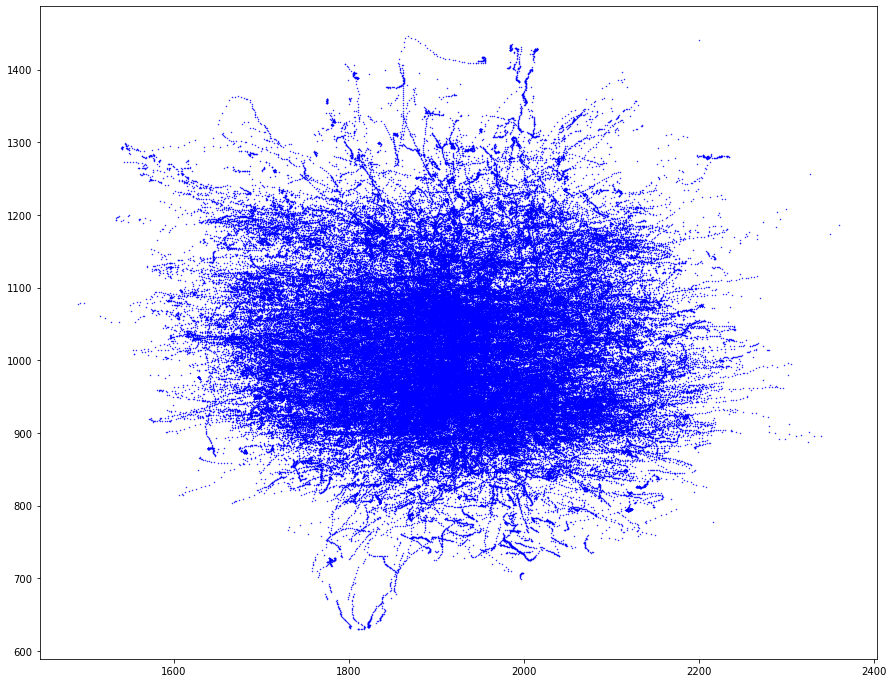

In [4]:

plt.figure(figsize = (15, 12))
plt.scatter(equrect[:,0],equrect[:,1], s=0.8, c='b', marker='.')



### 2.3 Perform GMM on the fov, head velocity and head acceleration

In [6]:
def plot_results(X, Y_, means, covariances, index, title,color_iter,gaussian = True):
    
    splot = plt.subplot(1, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue

        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 1, color=color)
        
        if gaussian :
            # Plot an ellipse to show the Gaussian component
            angle = np.arctan(u[1] / u[0])
            angle = 180. * angle / np.pi  # convert to degrees
            ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
            ell.set_clip_box(splot.bbox)
            ell.set_alpha(0.5)
            splot.add_artist(ell)
        
    centroid = np.zeros((len(means),2))
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        
        plt.scatter(np.mean(X[Y_ == i, 0]),np.mean(X[Y_ == i, 1]), 80, color="black")
        plt.scatter(np.mean(X[Y_ == i, 0]),np.mean(X[Y_ == i, 1]), 40, color=color)
        centroid[i,0] =  np.mean(X[Y_ == i, 0])
        centroid[i,1] =  np.mean(X[Y_ == i, 1])
    plt.title(title)
    return centroid


### 2.4 visualize results

0.18294861684732971
0.250852079072938
0.25733010768497355
0.21004138988019658
0.0988278065145622


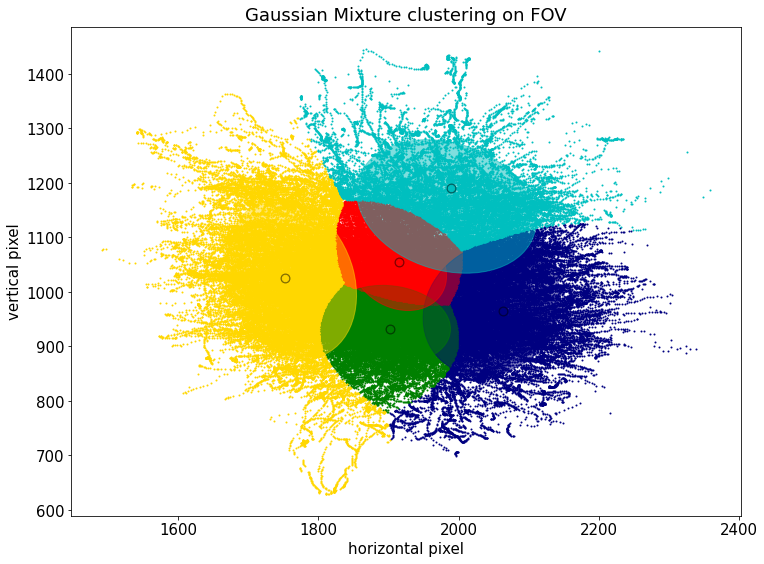

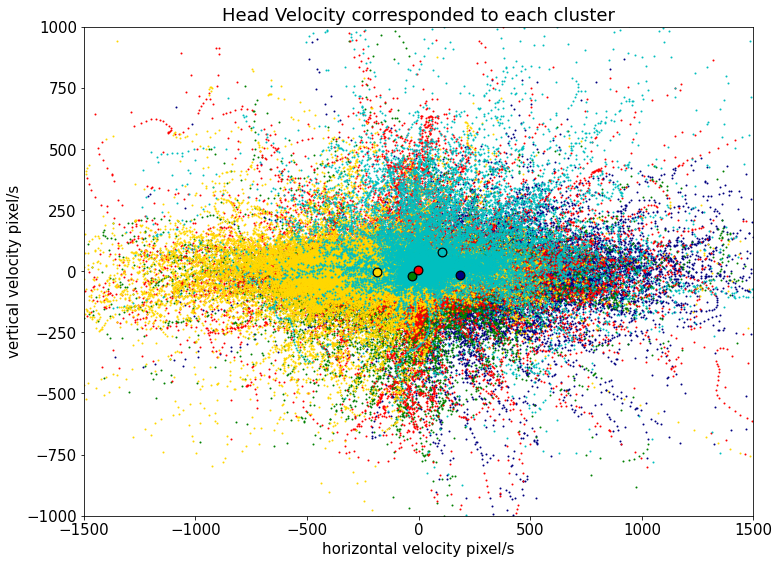

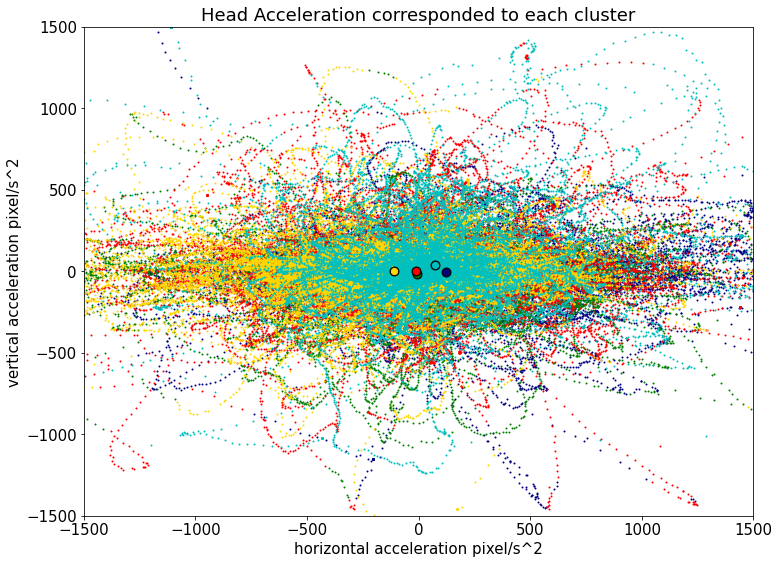

In [26]:
# run GMM on gaze samples
color = ['navy', 'g', 'r', 'gold','c']#,'cornflowerblue','darkorange','black','b','y']
n = 5
gmm = GaussianMixture(n_components=n, covariance_type='full').fit(equrect)



plt.figure(figsize = (12, 9))
centroidFov = plot_results(equrect, gmm.predict(equrect), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture clustering on FOV',itertools.cycle(color))

plt.xlabel('horizontal pixel')
plt.ylabel('vertical pixel')
plt.savefig("GMM.png",dpi=300)
gmmres = gmm.predict(equrect)
for i in range(n):
    print(len(gmmres[gmmres==i])/len(gmmres))

#------------------------------------------------------------------------------------------------
## apply the results to the velocity samples
plt.figure(figsize = (12, 9))
centroidV = plot_results(V, gmm.predict(equrect), gmm.means_, gmm.covariances_, 0,
             'Head Velocity corresponded to each cluster',itertools.cycle(color))


plt.xlim(-1500,1500)
plt.ylim(-1000,1000)
plt.xlabel('horizontal velocity pixel/s')
plt.ylabel('vertical velocity pixel/s')
plt.savefig("velocityGMM.png",dpi=300)
#-----------------------------------------------------------------------------------------------
## apply the results to the acceleration samples
plt.figure(figsize = (12, 9))
centroidA = plot_results(A, gmm.predict(equrect), gmm.means_, gmm.covariances_, 0,
             'Head Acceleration corresponded to each cluster',itertools.cycle(color))

plt.xlim(-1500,1500)
plt.ylim(-1500,1500)
plt.xlabel('horizontal acceleration pixel/s^2')
plt.ylabel('vertical acceleration pixel/s^2')
plt.savefig("accGMM.png",dpi=300)

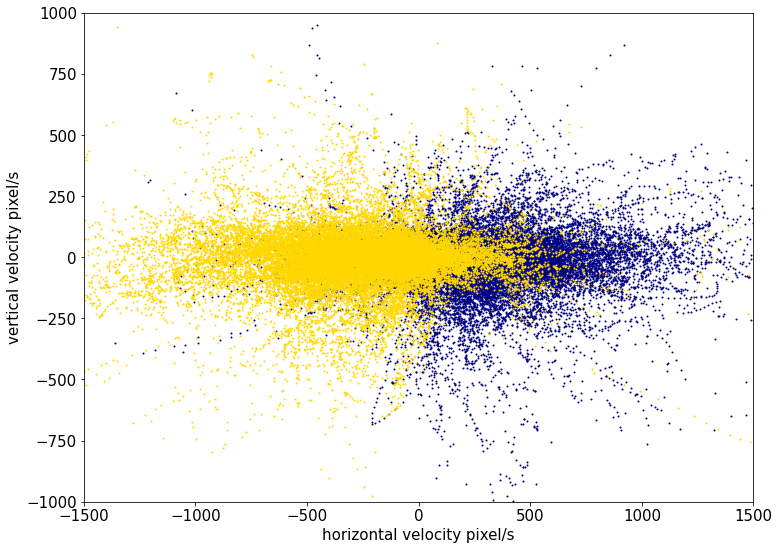

In [27]:
# visualize the left & right cluster's velocity to hace a clear view about the shifting of head velocity distribution

i = 3
plt.figure(figsize = (12, 9))
plt.scatter(V[gmm.predict(equrect) == 0,0],V[gmm.predict(equrect) == 0,1],1,color = "navy")
plt.scatter(V[gmm.predict(equrect) == 3,0],V[gmm.predict(equrect) == 3,1],1,color = 'gold')
plt.xlim(-1500,1500)
plt.ylim(-1000,1000)
plt.xlabel("horizontal velocity pixel/s")
plt.ylabel("vertical velocity pixel/s")
plt.savefig("leftright.png",dpi=300)

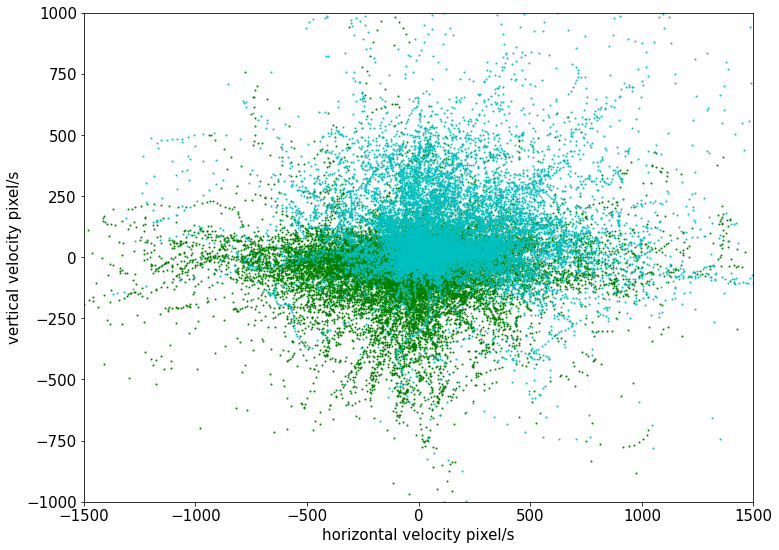

In [28]:




plt.figure(figsize = (12, 9))
plt.scatter(V[gmm.predict(equrect) == 1,0],V[gmm.predict(equrect) == 1,1],1,color = 'green')
plt.scatter(V[gmm.predict(equrect) == 4,0],V[gmm.predict(equrect) == 4,1],1,color = 'c')
plt.xlim(-1500,1500)
plt.ylim(-1000,1000)
plt.xlabel("horizontal velocity pixel/s")
plt.ylabel("vertical velocity pixel/s")
plt.savefig("updown.png",dpi=300)

### 2.5 GMM with different number of components

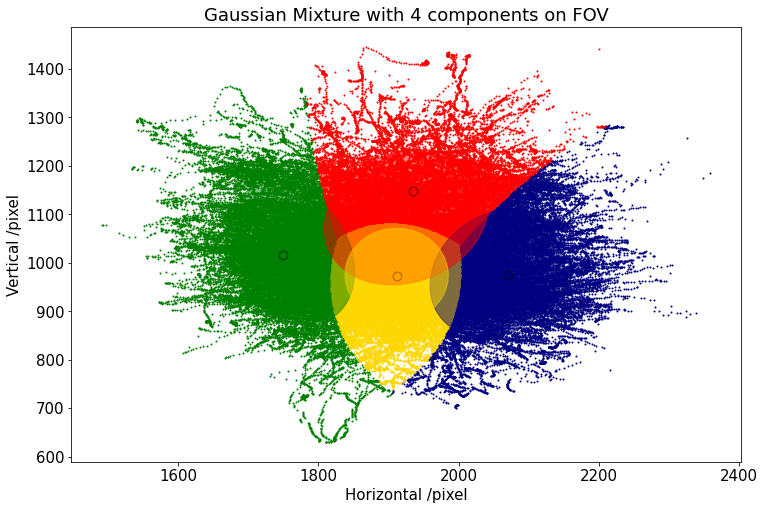

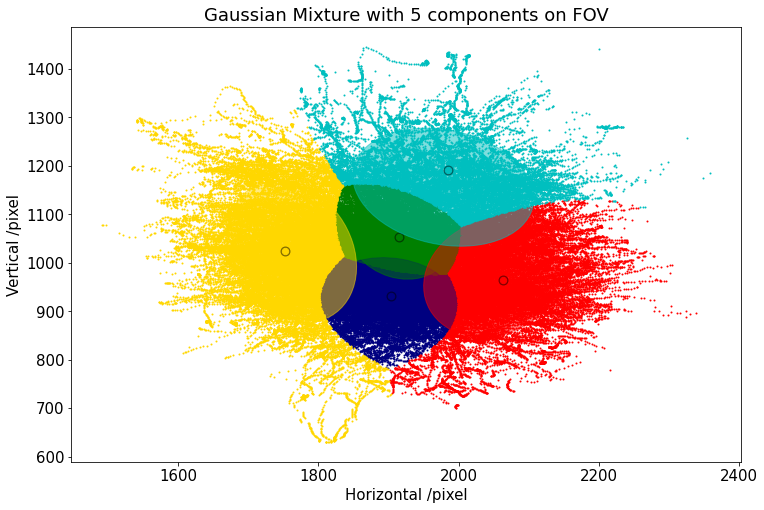

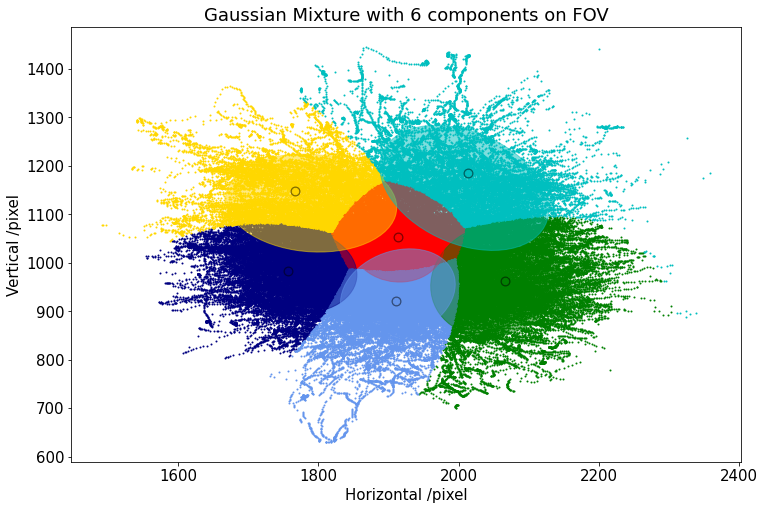

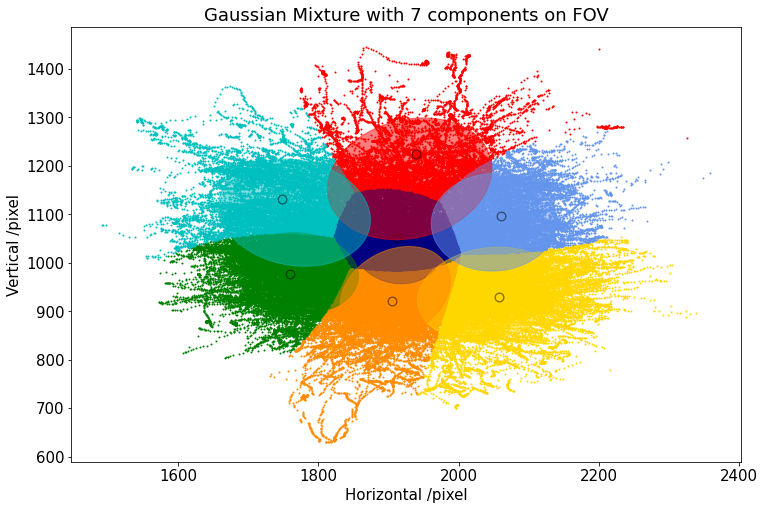

In [29]:


plt.figure(figsize = (12, 8))
n = 4
c = ['navy', 'g', 'r', 'gold']
color = c[:n+1]
gmm = GaussianMixture(n_components=n, covariance_type='full').fit(equrect)

plot_results(equrect, gmm.predict(equrect), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture with 4 components on FOV',itertools.cycle(color))

plt.xlabel("Horizontal /pixel")
plt.ylabel("Vertical /pixel")
plt.savefig('4.png',dpi = 300)


plt.figure(figsize = (12, 8))
n = 5

c = ['navy', 'g', 'r', 'gold','c']#,'cornflowerblue','darkorange','black','b','y']
color = c[:n+1]
gmm = GaussianMixture(n_components=n, covariance_type='full').fit(equrect)

plot_results(equrect, gmm.predict(equrect), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture with 5 components on FOV',itertools.cycle(color))
plt.xlabel("Horizontal /pixel")
plt.ylabel("Vertical /pixel")
plt.savefig('5.png',dpi = 300)

plt.figure(figsize = (12, 8))
n = 6
c = ['navy', 'g', 'r', 'gold','c','cornflowerblue']#,'darkorange','black','b','y']
color = c[:n+1]
gmm = GaussianMixture(n_components=n, covariance_type='full').fit(equrect)

plot_results(equrect, gmm.predict(equrect), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture with 6 components on FOV',itertools.cycle(color))
plt.xlabel("Horizontal /pixel")
plt.ylabel("Vertical /pixel")
plt.savefig('6.png',dpi = 300)


plt.figure(figsize = (12, 8))
n = 7
c = ['navy', 'g', 'r', 'gold','c','cornflowerblue','darkorange']#,'black','b','y']
color = c[:n+1]
gmm = GaussianMixture(n_components=n, covariance_type='full').fit(equrect)

plot_results(equrect, gmm.predict(equrect), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture with 7 components on FOV',itertools.cycle(color))
plt.xlabel("Horizontal /pixel")
plt.ylabel("Vertical /pixel")
plt.savefig('7.png',dpi = 300)
print("")

## 3 Use Supervised learning to predict gaze point from head data

### 3.1 Gaussian Process

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
import pickle
import numpy as np


import time
# training Gaussian Process
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(feature[:10000], target[:10000])




# save model
import pickle
with open('drive/MyDrive/model.pkl','wb') as f:
    pickle.dump(gpr,f)

# load model
with open('/Users/louitech_zero/VoidGaze/Data/model/model.pkl', 'rb') as f:
    gpr = pickle.load(f)
    
    
# plot results
pred = gpr.predict(feature[-20000:], return_std=True)
predmean = pred[0]
predstd = pred[1]


import matplotlib.pyplot as plt
import matplotlib
font = {'weight' :  'normal',
        'size'   : 15}
matplotlib.rc('font', **font)
plt.figure(figsize = (12, 8))
plt.scatter(target[:,0]*3840,target[:,1]*2048,1,'black',label="Full Samples")
plt.scatter(target[-20000:,0]*3840,target[-20000:,1]*2048,1,'r',label='ground truth')
plt.scatter(predmean[:,0]*3840,predmean[:,1]*2048,2,'b',label='prediction')

plt.xlabel('horizontal /pixel')
plt.ylabel('vertical /pixel')
plt.title('Prediction of FOV with Gaussian Process')
plt.legend()
plt.savefig('gp.png',dpi = 300)

### 3.2 Deep Neural Net Work

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import numpy 
import torch.optim as optim
class RegressionNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, init_w=3e-3, std_min=1e-10, std_max=1):
        super(RegressionNetwork, self).__init__()
        
        self.std_min = std_min
        self.std_max = std_max
        
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, hidden_size)

        self.bn1 = nn.BatchNorm1d(input_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)
        self.bn4 = nn.BatchNorm1d(hidden_size)
        
        self.leakyrelu = nn.LeakyReLU(0.1)
        
        self.mean_linear = nn.Linear(hidden_size, output_size)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)

        self.std_linear = nn.Linear(hidden_size, output_size)
        self.std_linear.weight.data.uniform_(-init_w, init_w)
        self.std_linear.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = self.leakyrelu(self.linear1(self.bn1(state)))
        #x = self.leakyrelu(self.linear2(x))
        x = self.leakyrelu(self.linear2(self.bn2(x)))
        #x = self.leakyrelu(self.linear3(x))
        #x = self.leakyrelu(self.bn3(self.linear3(x)))
        #x = self.leakyrelu(self.linear4(x))

        
        mean    = F.sigmoid(self.mean_linear(self.bn3(x)))
        std    = F.sigmoid(self.std_linear(self.bn4(x)))
        
        std = torch.clamp(std, self.std_min, self.std_max)
        
        return mean,std

In [5]:
# prepare training data set

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import numpy 
import torch.optim as optim
feature = None
feature = np.append(V,head_pose.reshape((-1,1)),axis =1)#
feature = np.append(feature,A,axis =1).astype(float)


feature[:,0]/=3840
feature[:,1]/=2048
feature[:,3]/=3840
feature[:,4]/=2048

Equrect = np.zeros(equrect.shape)
Equrect[:,0] = equrect[:,0]/3840
Equrect[:,1] = equrect[:,1]/2048

In [6]:
# initialize network
Model = RegressionNetwork(5,2,256)


trainf = torch.Tensor(feature[:-20000])
validf = torch.Tensor(feature[-20000:])



traint = torch.Tensor(Equrect[:-20000])
validt = torch.Tensor(Equrect[-20000:])


loss_criteria=nn.MSELoss()
batch = torch.randperm(len(traint))
r = 4801

In [375]:
# start training
for i in range(r):
    slices = (i%75)*2000
    samples = batch[slices:slices+2000]
    
    mean, std = Model(trainf[samples])
    gt = traint[samples]
    log_pdf = Normal(mean,std).log_prob(gt)
    
    loss = -log_pdf.exp().mean() + 4*loss_criteria(std,torch.zeros(std.shape))#12/(1e-10+log_pdf.exp().mean()) + 6*loss_criteria(mean,gt) + 5*loss_criteria(std,abs(gt-mean)/1.645) +#2*abs(std.mean())

    optimizer = optim.Adam(Model.parameters(), lr=1e-5)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%400 == 0 or i ==r-1:
        print("Iteration: ",i)
        print("Train Loss: ",loss.item())
        meanv, stdv = Model(validf)
        log_pdfv = Normal(meanv,stdv).log_prob(validt)
    
        lossv =-log_pdfv.exp().mean() + 4*loss_criteria(stdv,torch.zeros(stdv.shape)) #12/log_pdfv.exp().mean() + 6*loss_criteria(meanv,validt) + 5*loss_criteria(stdv,abs(validt-meanv)/1.645)#2*abs(stdv.mean())
        print("Validation Loss: ",lossv.item())

/Users/louitech_zero/opt/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iteration:  0
Train Loss:  0.20600610971450806
Validation Loss:  0.20515960454940796
Iteration:  400
Train Loss:  0.19309645891189575
Validation Loss:  0.1926175355911255
Iteration:  800
Train Loss:  0.169322669506073
Validation Loss:  0.16892433166503906
Iteration:  1200
Train Loss:  0.13422799110412598
Validation Loss:  0.1338697075843811
Iteration:  1600
Train Loss:  0.08793997764587402
Validation Loss:  0.08750885725021362
Iteration:  2000
Train Loss:  0.030341744422912598
Validation Loss:  0.029930472373962402
Iteration:  2400
Train Loss:  -0.03833979368209839
Validation Loss:  -0.03873789310455322
Iteration:  2800
Train Loss:  -0.1178961992263794
Validation Loss:  -0.11839663982391357
Iteration:  3200
Train Loss:  -0.20844262838363647
Validation Loss:  -0.20895302295684814
Iteration:  3600
Train Loss:  -0.7443299889564514
Validation Loss:  -0.5431463718414307
Iteration:  4000
Train Loss:  -0.8951531648635864
Validation Loss:  -0.7821636199951172
Iteration:  4400
Train Loss:  -0.9

[[0.48226655 0.52240807]
 [0.4817566  0.52035636]
 [0.48105773 0.51910216]
 ...
 [0.49469018 0.48215014]
 [0.49463642 0.48215854]
 [0.49469346 0.48262003]] [[0.03549117 0.04125307]
 [0.03289441 0.03956281]
 [0.03178392 0.03909656]
 ...
 [0.01788066 0.03454938]
 [0.01790761 0.03462029]
 [0.01789068 0.0346289 ]]


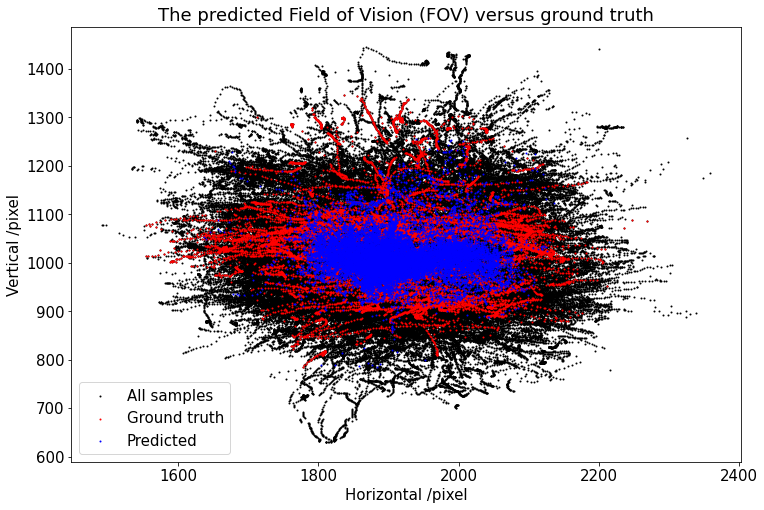

In [10]:
# plot resultant gaze position
from matplotlib.patches import Ellipse
m, s = Model(validf)
M = m.detach().cpu().numpy()
s = s.detach().cpu().numpy()
va = validt.detach().cpu().numpy()
res = M-va
plt.figure(figsize = (12, 8))
ax = plt.gca()
plt.scatter(equrect[:,0],equrect[:,1],1,color = 'black',label='All samples')

domain = 20000-1
plt.scatter(va[:domain,0]*3840,va[:domain,1]*2048,1,color = 'red',label='Ground truth')
plt.scatter(M[:domain,0]*3840,M[:domain,1]*2048,1,color = 'blue',label='Predicted')



conf = 2*1.645*s



plt.xlabel("Horizontal /pixel")
plt.ylabel("Vertical /pixel")

plt.title("The predicted Field of Vision (FOV) versus ground truth")
plt.legend()
plt.savefig("./fig/DNNres.png", dpi=500)

### 3.3 Mixture Density Network

In [4]:
# example of using pre trained model
import torch
from MixtureDensityNet import MixtureDensityNetwork
Model = MixtureDensityNetwork(5,5,256)
Model.load_state_dict(torch.load('/Users/louitech_zero/VoidGaze/data/model/MDN.dat',torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# training process
torch.autograd.set_detect_anomaly(True)
for i in range(r):
    slices = (i%75)*2000
    samples = batch[slices:slices+2000]
  
    loss = Model.compute_loss(trainf[samples],traint[samples])

    optimizer = optim.Adam(Model.parameters(), lr=1e-5)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%400 == 0 or i ==r-1:
        print("Iteration: ",i)
        print("Train Loss: ",loss.item())

        lossv = Model.compute_loss(validf,validt) # + 5000*loss_criteria(meanv,validt.contiguous().view(-1, 2))+ 10*loss_criteria(stdv,torch.zeros(stdv.shape).to('cuda')) #12/log_pdfv.exp().mean()  + 5*loss_criteria(stdv,abs(validt-meanv)/1.645)#2*abs(stdv.mean())
        print("Validation Loss: ",lossv.item())

In [ ]:
# convert model to ONNX files

In [16]:
dummy_input = validf[0].reshape(1,5)
torch.onnx.export(Model, 
                  dummy_input,
                  "VoidGaze.onnx",
                  verbose=False,
                  input_names="head",
                  output_names=["mean","std","weights"],
                  export_params=True,)


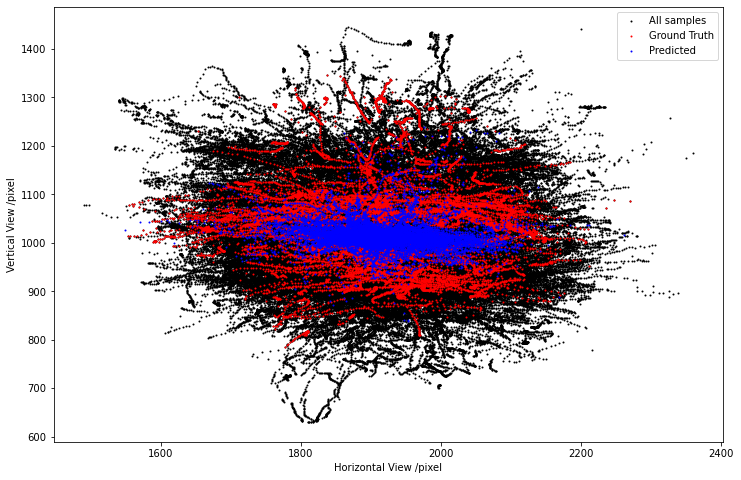

In [67]:
# plot results
import matplotlib.pyplot as plt


va = (validt).detach().cpu().numpy()

plt.figure(figsize = (12, 8))
ax = plt.gca()
plt.scatter(equrect[:,0],equrect[:,1],1,color = 'black',label = 'All samples')

domain = 20000-1
plt.scatter(va[:domain,0]*3840,va[:domain,1]*2048,1,color = 'red',label = 'Ground Truth')
plt.scatter(resultant_mean[:domain,0].detach().cpu().numpy()*3840,resultant_mean[:domain,1].detach().cpu().numpy()*2048,1,color = 'blue',label = "Predicted")

plt.legend()
plt.xlabel("Horizontal View /pixel")
plt.ylabel("Vertical View /pixel")
plt.savefig("MDN.png", dpi=500)


### 3.4 SaliencyMDN

#### 3.41 prepare dataset for saliency map model

In [5]:
gazedata = GazeHeadMovement('/Users/louitech_zero/Desktop/360_em_dataset/ground_truth/train/006_05_cycling_jpKn9fRfGIU.arff')

In [3]:
count = 0

for i in ['/Users/louitech_zero/Desktop/360_em_dataset/ground_truth/train/006_05_cycling_jpKn9fRfGIU.arff']:
    gazedata = GazeHeadMovement(i)
    gaze_equrect = np.zeros((len(gazedata.gaze_fov),2))
    v,a = gazedata.getEquirectRes()
    t = gazedata.timestamp
    h = gazedata.angle_head
    for j in range(len(gazedata.gaze_fov)):
        Rads = Cart2Spher(gazedata.gaze_fov[j])
        gaze_equrect[j] = Spher2Equ(Rads[0],Rads[1],gazedata.meta['width_px'],gazedata.meta["height_px"])    
    if count == 0:
        equrect = gaze_equrect
        V = v
        T = t
        A = a
        head_pose = h
        BreakPoint = [len(a)]
        size = [gazedata.meta['height_px']]
        
    else:
        equrect = np.append(equrect,gaze_equrect,axis = 0 )
        V = np.append(V,v,axis = 0 )
        A = np.append(A,a,axis = 0 )
        T = np.append(T,t,axis = 0 )
        head_pose = np.append(head_pose,h,axis = 0 )
        BreakPoint.append(len(a))
        size.append(gazedata.meta['height_px'])
    count+=1


for i in range(len(V)):
    if abs(V[i,0]) > 2500:
        V[i] = V[i-1]
    if abs(A[i,0]) > 2500:
        A[i] = A[i-1]     
    if abs(V[i,1]) > 1500:
        V[i] = V[i-1]
    if abs(A[i,1]) > 1500:
        A[i] = A[i-1] 

In [ ]:
# prepare saliency map detector's input from video
import numpy as np
import cv2

import torch
import torch.nn as nn
from salicon_model import Salicon

from PIL import Image
from torchray.utils import imsc
from torchvision import transforms

import matplotlib.pyplot as plt
def prepareIMG(model_trained,data,posdata,left,length,videoframe):
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cap= cv2.VideoCapture('drive/MyDrive/saliency_map/05_cycling_jpKn9fRfGIU.mp4')
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.set(1,videoframe)
    c = 0
    ret, frame = cap.read()
    cv2.imwrite("image.png",frame)
    output = None
    f = videoframe
    for j in range(length):
        

        i = left + j
        if data[i,-1] > 1/fps * f:
            f+=1
            ret, frame = cap.read()
            if ret == True:
                cv2.imwrite("image.png",frame)
            else:
                f -= 1
        
        t1 = time.time()
        img_tensor_coarse = image2tensor("image.png",center = (posdata[i,0],posdata[i,1])).to(device)
        img_tensor_fine = image2tensor("image.png",resolution = 2,center = (posdata[i,0],posdata[i,1])).to(device)

        saliency_map = model_trained(img_tensor_fine,img_tensor_coarse).to(device)

        pred_image=saliency_map.squeeze()


        smap=(pred_image-torch.min(pred_image))/((torch.max(pred_image)-torch.min(pred_image)))
        smap=smap.detach().cpu().numpy()
        smap=cv2.resize(smap,(144,128),interpolation=cv2.INTER_CUBIC)
        smap=cv2.GaussianBlur(smap,(75,75),8,cv2.BORDER_DEFAULT)


        print(time.time() - t1)
        if c == 0:
            output = np.expand_dims(smap, axis=0)
        else:
            output = np.append(output,np.expand_dims(smap, axis=0),axis = 0)
        c+=1


    print(f,data[i,-1],1/fps * f,output.shape)


    return output, f






model_weight = 'salicon_model.pth'

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_trained= Salicon()
model_trained.load_state_dict(torch.load(model_weight,map_location=torch.device('cpu')))
model_trained.to(device)
model_trained.eval()

cycle = np.load('cycle.npy', allow_pickle=True)
posdata = np.load('pos.npy', allow_pickle=True)

saliency,frame = prepareIMG(model_trained,cycle,posdata,7000,734,1824)



In [ ]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import numpy 
import torch.optim as optim

import torchvision.models as models

class CombinedNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, init_w=3e-3, std_min=1e-10, std_max=1):
        super(CombinedNetwork, self).__init__()
        
        self.std_min = std_min
        self.std_max = std_max
        self.hidden_dim = hidden_size
        self.output_size = output_size

        self.linear1 = nn.Linear(input_size,hidden_size)
        self.linearimg = nn.Linear(1000,hidden_size)
        self.linear2 = nn.Linear(hidden_size*2, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, hidden_size)

        

        self.bn1 = nn.BatchNorm1d(hidden_size*2)
        #self.bn2 = nn.BatchNorm1d(hidden_size)
        #self.bn3 = nn.BatchNorm1d(hidden_size)
        

        self.leakyrelu = nn.LeakyReLU(0.0001)
        
        self.mean_linearX = nn.Linear(hidden_size, output_size)
        self.mean_linearY = nn.Linear(hidden_size, output_size)


        self.std_linearX = nn.Linear(hidden_size, output_size)
        self.std_linearY = nn.Linear(hidden_size, output_size)


        self.weight_linear = nn.Linear(hidden_size, output_size)
        self.loss_criteria=nn.MSELoss()
    def forward(self, state, saliency):

        #integrated_input = torch.cat((state,saliency), 1)
        
        x = self.leakyrelu(self.linear1(state))
        ximg = self.leakyrelu(self.linearimg(saliency))

        integrated = torch.cat((x,ximg), 1)
        x = self.leakyrelu(self.linear2(self.bn1(integrated)))
        x = self.leakyrelu(self.linear3(x))
        x = self.leakyrelu(self.linear4(x))

        meanX    = torch.sigmoid(self.mean_linearX(x)).reshape(-1,1,self.output_size)
        meanY    = torch.sigmoid(self.mean_linearY(x)).reshape(-1,1,self.output_size)
        stdX    = torch.sigmoid(self.std_linearX(x)).reshape(-1,1,self.output_size)
        stdY    = torch.sigmoid(self.std_linearY(x)).reshape(-1,1,self.output_size)
        weights = F.softmax(self.weight_linear(x),dim=1).reshape(-1,self.output_size,1)

        
        return torch.cat((meanX,meanY),1) , torch.cat((stdX,stdY),1), weights
    def compute_loss(self,state,saliency,targets):
        reshaped_targets = targets.reshape(-1,2,1)
        for i in range(self.output_size-1):
            reshaped_targets = torch.cat((reshaped_targets,targets.reshape(-1,2,1)),2)
        means,stds,weights = self.forward(state,saliency)
        mixed_pdf = mixed_prob(means,stds,weights,reshaped_targets)
        '''print('pdf',mixed_pdf[0])
        print('mean',means[0])
        print('std',stds[0])
        print('weights',weights[0])'''

        checker = (mixed_pdf != torch.zeros(mixed_pdf.shape).to('cuda'))
        mixed_pdf = mixed_pdf.where(checker, torch.tensor(0.0000001).to('cuda'))

        return -torch.log(mixed_pdf).mean() #+ 100*self.loss_criteria(torch.matmul(means,weights).reshape(-1,2),targets).mean()
def mixed_prob(means,stds,weights,validt):
    #checker = (stds != torch.zeros(stds.shape).to('cuda'))
    #stds = stds.where(checker, torch.tensor(0.000001).to('cuda')) 
    #print(stds)  
    prob = Normal(means,stds).log_prob(validt).exp()
    
    return torch.matmul(prob,weights).reshape(-1,2)

In [ ]:

# Initialize model
Model = SaliencyMixedDensityNetwork(5,5,256).to("cuda")


# prepare inputs 
saliency = np.load('Saliency.npy', allow_pickle=True)
cycle = np.load('cycle.npy', allow_pickle=True)
posdata = np.load('pos.npy', allow_pickle=True)
target = np.load('target.npy', allow_pickle=True)
target[:,0]/=3840
target[:,1]/=1920
V = torch.Tensor(saliency).to("cuda")
Fe = torch.Tensor(cycle[:,:-1]).to("cuda")
T = torch.Tensor(target).to("cuda")

trainf = Fe[:-1500]
validf = Fe[-1500:]

trainS = V[:-1500]
validS = V[-1500:]

traint = T[:-1500]
validt = T[-1500:]


loss_criteria=nn.MSELoss()
batch = torch.randperm(len(traint))
r = 3201


#train model
for i in range(r):
    slices = (i%60)*100
    samples = batch[slices:slices+100]
    #if i != 0:
    #    del trainimage
    #trainimage = trainS[samples].to('cuda')
    loss = Model.compute_loss(trainf[samples],trainS[samples],traint[samples])

    optimizer = optim.Adam(Model.parameters(), lr=2e-5)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%400 == 0 or i ==r-1:

        print("Iteration: ",i)
        print("Train Loss: ",loss.item())

        lossv = Model.compute_loss(validf,validS,validt) # + 5000*loss_criteria(meanv,validt.contiguous().view(-1, 2))+ 10*loss_criteria(stdv,torch.zeros(stdv.shape).to('cuda')) #12/log_pdfv.exp().mean()  + 5*loss_criteria(stdv,abs(validt-meanv)/1.645)#2*abs(stdv.mean())
        print("Validation Loss: ",lossv.item())

In [ ]:
# plot results
import matplotlib
font = {'weight' :  'normal',
        'size'   : 15}
matplotlib.rc('font', **font)
means,stds,weights = Model(Fe,V)
resultant_mean =torch.matmul(means,weights).reshape(-1,2)
resultant_std =torch.matmul(stds,weights).reshape(-1,2).detach().cpu().numpy()
res = abs(resultant_mean - T).detach().cpu().numpy()
print(np.mean(res[:,0])*360,np.mean(res[:,1])*180)

import matplotlib.pyplot as plt



plt.figure(figsize = (12, 8))

domain = 1500
plt.scatter(target[:,0]*3840,target[:,1]*1920,1,'black',label="Full Samples")

plt.scatter(T[:domain,0].detach().cpu().numpy()*3840,T[:domain,1].detach().cpu().numpy()*1920,5,color = 'red',label="Ground truth")
plt.scatter(resultant_mean[:domain,0].detach().cpu().numpy()*3840,resultant_mean[:domain,1].detach().cpu().numpy()*1920,3,color = 'b',label= 'Predicted')
plt.xlabel('horizontal /pixel')
plt.ylabel('vertical /pixel')

plt.legend()
plt.savefig("salnet_res.png")